In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:

# Set the path to the dataset
data_dir = "/kaggle/input/eye-disease/data"


In [3]:
img_height, img_width = 224, 224 # Typical for VGG16
batch_size = 64
num_classes = 14 # Update as needed
initial_epochs = 50
fine_tune_epochs = 10 # Additional epochs after unfreezing
initial_lr = 1e-4



# Data augmentation and loading remain the same
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], # Experimental brightness changes
    fill_mode='nearest',
    validation_split=0.2
    )

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
    )

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
    )

Found 560 images belonging to 14 classes.
Found 140 images belonging to 14 classes.


In [4]:
# Get the mapping of class indices
class_indices = train_generator.class_indices
print("Class indices:")
print(class_indices)

# Get the list of classes
classes = list(class_indices.keys())
print("Classes:")
print(classes)

Class indices:
{'ACRIMA': 0, 'Central Serous Chorioretinopathy': 1, 'Disc Edema': 2, 'Macular Scar': 3, 'Myopia': 4, 'ODIR-5K': 5, 'ORIGA': 6, 'Pterygium': 7, 'Retinal Detachment': 8, 'Retinitis Pigmentosa': 9, 'cataract': 10, 'diabetic_retinopathy': 11, 'glaucoma': 12, 'normal': 13}
Classes:
['ACRIMA', 'Central Serous Chorioretinopathy', 'Disc Edema', 'Macular Scar', 'Myopia', 'ODIR-5K', 'ORIGA', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa', 'cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


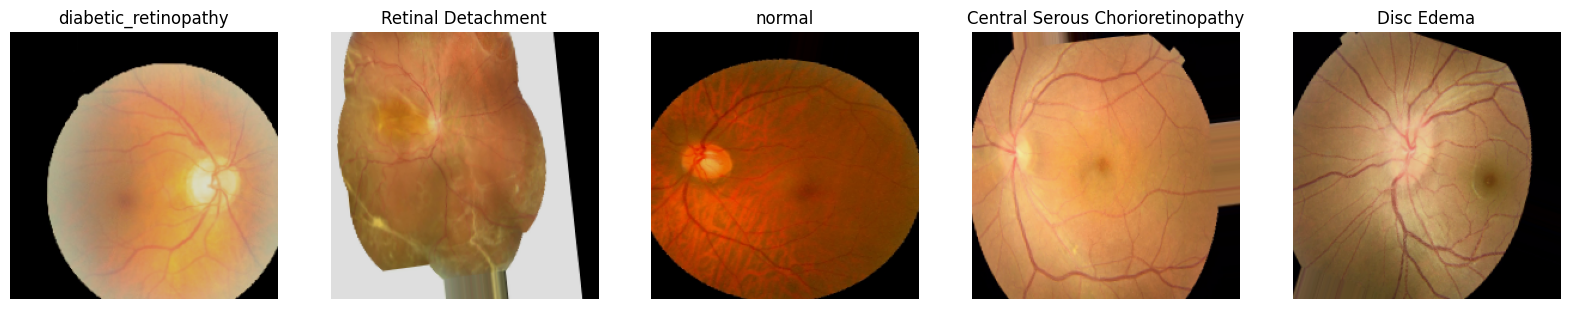

In [5]:
# Get a batch of images and labels
images, labels = next(train_generator)

# Plot images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for img, label, ax in zip(images[:5], labels[:5], axes):
    ax.imshow(img)
    class_name = classes[np.argmax(label)]
    ax.set_title(class_name)
    ax.axis('off')
plt.show()

In [6]:
# Load the VGG16 model without the top layer (include_top=False)
base_model = VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
base_model,
Flatten(),
Dense(512, activation='relu'), # Increased layer size
Dropout(0.5),
Dense(num_classes, activation='softmax')
])

model.compile(
optimizer=Adam(learning_rate=initial_lr),
loss='categorical_crossentropy',
metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           7,182 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,567,438 (105.16 MB)

 Trainable params: 12,852,750 (49.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
early_stopping = EarlyStopping(
monitor='val_loss',
patience=3, # Stop if val_loss does not improve for 3 epochs
restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
monitor='val_loss',
factor=0.2, # Reduce learning rate by a factor of 0.2
patience=2, # If val_loss doesn’t improve for 2 epochs, reduce LR
min_lr=1e-7 # Do not reduce below this
)

callbacks = [early_stopping, reduce_lr]

In [8]:
# Train the model
history_initial = model.fit(
train_generator,
steps_per_epoch=train_generator.samples // batch_size,
validation_data=validation_generator,
validation_steps=validation_generator.samples // batch_size,
epochs=initial_epochs,
callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.1117 - loss: 2.8735 - val_accuracy: 0.5000 - val_loss: 1.8796 - learning_rate: 1.0000e-04
Epoch 2/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3906 - loss: 2.0922

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step - accuracy: 0.3906 - loss: 2.0922 - val_accuracy: 0.0000e+00 - val_loss: 2.8496 - learning_rate: 1.0000e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 754ms/step - accuracy: 0.4390 - loss: 1.8002 - val_accuracy: 0.5156 - val_loss: 1.5431 - learning_rate: 1.0000e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4688 - loss: 1.6631 - val_accuracy: 0.5000 - val_loss: 1.7145 - learning_rate: 1.0000e-04
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 694ms/step - accuracy: 0.5614 - loss: 1.3577 - val_accuracy: 0.5703 - val_loss: 1.2507 - learning_rate: 1.0000e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5000 - loss: 1.4096 - val_accuracy: 0.2500 - val_loss: 2.3806 - learning_rate: 1.0000e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 719ms/step - accuracy: 0.6402 - loss: 1.1519 - val_accuracy: 0.5547 - val_loss: 1.2100 - learning_rate: 1.0000e-04
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7188 - loss: 1.0807 - 

In [9]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

fine_tune_lr = 1e-5
model.compile(
optimizer=Adam(learning_rate=fine_tune_lr),
loss='categorical_crossentropy',
metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │           7,182 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,567,438 (105.16 MB)

 Trainable params: 19,932,174 (76.04 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [10]:
history_fine_tune = model.fit(
train_generator,
steps_per_epoch=train_generator.samples // batch_size,
validation_data=validation_generator,
validation_steps=validation_generator.samples // batch_size,
epochs=fine_tune_epochs,
callbacks=callbacks
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6630 - loss: 1.0039 - val_accuracy: 0.5859 - val_loss: 1.0369 - learning_rate: 1.0000e-05
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7812 - loss: 0.7398 - val_accuracy: 0.2500 - val_loss: 1.9721 - learning_rate: 1.0000e-05
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 749ms/step - accuracy: 0.7230 - loss: 0.8217 - val_accuracy: 0.6406 - val_loss: 0.9897 - learning_rate: 1.0000e-05
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7500 - loss: 0.8216 - val_accuracy: 0.5000 - val_loss: 1.5497 - learning_rate: 1.0000e-05
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 714ms/step - accuracy: 0.7046 - loss: 0.8251 - val_accuracy: 0.6094 - val_loss: 1.0165 - learning_rate: 1.0000e-05
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7969 - loss: 0.6954 - val_accuracy: 0.5000 - val_loss: 1.4061 - learning_rate: 2.0000e-06


In [11]:
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy*100}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6458 - loss: 0.9186
Validation Loss: 1.0078651905059814
Validation Accuracy: 60.9375%


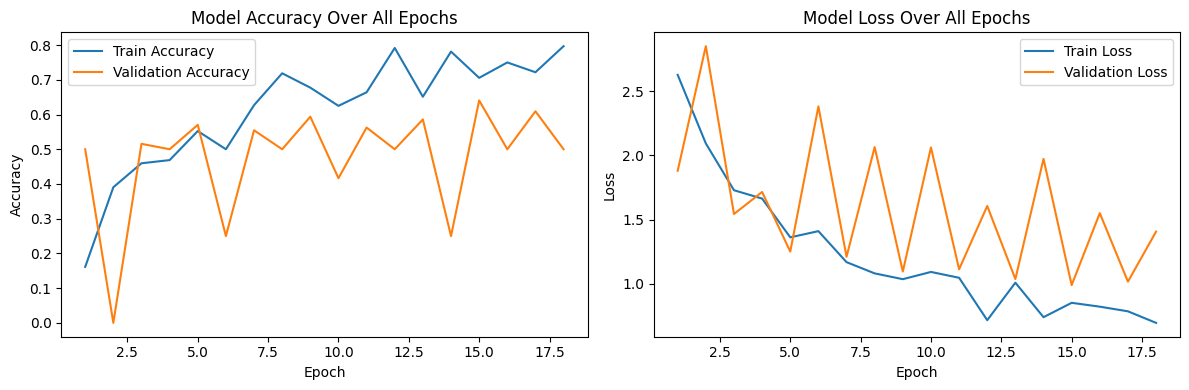

In [12]:
# Extract accuracy and loss from the initial training history
acc_initial = history_initial.history['accuracy']
val_acc_initial = history_initial.history['val_accuracy']
loss_initial = history_initial.history['loss']
val_loss_initial = history_initial.history['val_loss']

# Extract accuracy and loss from the fine-tuning history
acc_fine = history_fine_tune.history['accuracy']
val_acc_fine = history_fine_tune.history['val_accuracy']
loss_fine = history_fine_tune.history['loss']
val_loss_fine = history_fine_tune.history['val_loss']

# Combine them into single lists
acc_combined = acc_initial + acc_fine
val_acc_combined = val_acc_initial + val_acc_fine
loss_combined = loss_initial + loss_fine
val_loss_combined = val_loss_initial + val_loss_fine

# Create a range of epoch numbers for plotting
total_epochs = len(acc_combined)
epochs_range = range(1, total_epochs + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_combined, label='Train Accuracy')
plt.plot(epochs_range, val_acc_combined, label='Validation Accuracy')
plt.title('Model Accuracy Over All Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_combined, label='Train Loss')
plt.plot(epochs_range, val_loss_combined, label='Validation Loss')
plt.title('Model Loss Over All Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()